Imports

In [ ]:
import warnings
warnings.simplefilter('ignore')
!pip install rouge
!pip install bert_score
from google.colab import drive
drive.mount('/ProjectNLP', force_remount=True)
import os
os.chdir('/ProjectNLP') 
from bert_score import score
!git clone https://github.com/Tiiiger/bert_score.git
from rouge import Rouge
import gensim.downloader as api
model = api.load('word2vec-google-news-300')
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import editdistance
from scipy import spatial
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
import networkx as nx
import nltk
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
import nltk
nltk.download('stopwords')
import numpy as np
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import pickle
import re
import matplotlib.pyplot as plt
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer

Preparation of embeddings

In [ ]:
GloveVec = open(os.getcwd()+"/My Drive/ProjectNLP/"+'glove.6B.100d.txt', encoding="utf8")
#Extract word vectors
word_embeddings = {}
# f =open(GloveVec)
for line in GloveVec:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  word_embeddings[word] = coefs

In [ ]:
RPVec = open(os.getcwd()+"/My Drive/ProjectNLP/"+'myModel_splitsize100v2.txt', encoding="utf8")
word_embeddings_RP = {}
# f =open(GloveVec)
for line in RPVec:
  values = line.split()
  word = values[0]

  coefs = np.asarray(values[1:], dtype='float32')
  word_embeddings_RP[word.strip('"').strip("'")] = coefs

In [ ]:
w2v_300_ft = open(os.getcwd()+"/My Drive/ProjectNLP/"+'w2v_300_ft.txt', encoding="utf8")
word_embeddings_w2v_300_ft = {}
# f =open(GloveVec)
for line in w2v_300_ft:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  word_embeddings_w2v_300_ft[word.strip('"').strip("'")] = coefs

In [ ]:
w2v_300_ft_1 = open(os.getcwd()+"/My Drive/ProjectNLP/"+'w2v_300_ft_1.txt', encoding="utf8")
word_embeddings_w2v_300_ft_1 = {}
# f =open(GloveVec)
for line in w2v_300_ft_1:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  word_embeddings_w2v_300_ft_1[word.strip('"').strip("'")] = coefs

Function to calculate ROUGE score

In [ ]:
def getrougescore(genSummary,Highlights_Dict):
  generatedSummary={}
  for key in genSummary.keys():
    summattach=''
    for sent in genSummary[key][:k]:
      summattach+=sent+" "
    generatedSummary[key]=summattach
        # generatedSummary=genSummary
  return (rouge.get_scores(generatedSummary.values(),Highlights_Dict.values(),avg=True))


Function to calculate BERT score

In [ ]:
def getBertScore(genSummary,Highlights_Dict):
  cands=[]
  refs=[]
  generatedSummary={}
      
  for key in genSummary.keys():
    summattach=''
    for sent in genSummary[key][:k]:
      summattach+=sent+" "
    generatedSummary[key]=summattach

  for key in Highlights_Dict.keys():
    cands.append(generatedSummary[key])
    refs.append(Highlights_Dict[key])
  P, R, F1 = score(cands, refs, lang="en", verbose=True)
  return F1.mean()

Function to calculate Word Mover's Distance

In [ ]:

def getWMDScore(genSumm,givenSumm):
  score=0
  cnt=0
  for key in genSumm.keys():
    cnt+=1
    
    score+= model.wmdistance(getValidTokens(genSumm[key]),getValidTokens(givenSumm[key]))
  return score/cnt

Function to get the vectorized form which is then passed to clustering method

In [ ]:
def getVectorisedForm(clean_df,colName):
    # vectorisers=['TFIDF','Glove100','GoogleNewsModel','RPModel','w2v_ft','w2v_ft_1] 
    if colName=='TFIDF':
      vectorizer = TfidfVectorizer(max_df=0.95,min_df=0.05,stop_words='english',tokenizer=tokenize, max_features=25000)  ##plz give max feature
      vectorised_form= (vectorizer.fit_transform(clean_df))
    if colName=='GoogleNewsModel':

    # terms = (vectorizer.get_feature_names())
      vectorised_form=[]
      
      for data in clean_df:
        sum=0
        cnt=0
        avg=np.zeros((300,))
        tokens=getValidTokens(data)
        for word in tokens:
          if word in model.vocab:
            sum+=model[word]
            cnt+=1
        if(cnt!=0):  
          avg=sum/cnt
        else:
          avg=np.zeros((300,))
        vectorised_form.append(avg)
    if colName=='Glove100':
      vectorised_form=[]
      
      for data in clean_df:
        sum=0
        cnt=0
        avg=np.zeros((100,))
        tokens=getValidTokens(data)
        for word in tokens:
          if word in word_embeddings.keys():
            sum+=word_embeddings[word]
            cnt+=1
        if(cnt!=0):  
          avg=sum/cnt
        else:
          avg=np.zeros((100,))
        vectorised_form.append(avg)
    if colName=='RPModel':
      vectorised_form=[]
      
      for data in clean_df:
        sum=0
        cnt=0
        avg=np.zeros((100,))
        tokens=getValidTokens(data)
        for word in tokens:
          
          if word in word_embeddings_RP.keys():
            # print(word)
            sum+=word_embeddings_RP[word]
            cnt+=1
        if(cnt!=0):  
          avg=sum/cnt
        else:
          avg=np.zeros((100,))
        vectorised_form.append(avg)
    if colName=='w2v_ft':
      vectorised_form=[]
      
      for data in clean_df:
        sum=0
        cnt=0
        avg=np.zeros((300,))
        tokens=getValidTokens(data)
        for word in tokens:
          
          if word in word_embeddings_w2v_300_ft.keys():
            # print(word)
            sum+=word_embeddings_w2v_300_ft[word]
            cnt+=1
        if(cnt!=0):  
          avg=sum/cnt
        else:
          avg=np.zeros((300,))
        vectorised_form.append(avg)
    if colName=='w2v_ft_1':
      vectorised_form=[]
      
      for data in clean_df:
        sum=0
        cnt=0
        avg=np.zeros((300,))
        tokens=getValidTokens(data)
        for word in tokens:
          
          if word in word_embeddings_w2v_300_ft_1.keys():
            # print(word)
            sum+=word_embeddings_w2v_300_ft_1[word]
            cnt+=1
        if(cnt!=0):  
          avg=sum/cnt
        else:
          avg=np.zeros((300,))
        vectorised_form.append(avg)
    # vector_form=vectorised_form
    return vectorised_form

    # print(len(terms))
    

Function to get the summaries using TF-IDF, TextRank and Ensemble (all)

In [ ]:

def getSummary(sentence_df,topk,methods=['all','only_tfidf','only_textRank'],includeRandomness=False):
  TextRankScore={}
  tfidfScore={}
  summarymain={}
  sentenceindexmain={}
  for filename in sentence_df:
    # print(filename)
    sentenceindex=[]
    tokenisedSentence=[]
    sentence_score1=[]
    sentence_score2=[]
    mainscore=[]
    for sentence in sentence_df[filename]:
      # print(sentence)
      sentenceindex.append(sentence)
      tokenisedSentence.append(getValidTokens(sentence))
    sentenceindexmain[filename]=sentenceindex
    if(methods=='only_tfidf' or methods=='all'):
      sentence_score1=getSenttfidfScore(tokenisedSentence,filename)
      mainscore=sentence_score1
      tfidfScore[filename]=mainscore
    if(methods=='only_textRank' or methods=='all'):
      sentence_score2=gettextrankScore(tokenisedSentence)
      mainscore=np.array(sentence_score2)
      TextRankScore[filename]=mainscore
    if(methods=='all'):
      mainscore=sentence_score1+sentence_score2
    # if includeRandomness:
    #   summarymain[filename]=getSummaryIntro( mainscore/mainscore.sum(axis=0,keepdims=1),sentenceindex)
    
    # else:
    #   summarymain[filename]=getSummaryTop(mainscore/mainscore.sum(axis=0,keepdims=1),sentenceindex,topk)
      summarymain[filename]=getSummaryTop(mainscore/mainscore.sum(axis=0,keepdims=1),sentenceindex,topk)
  return tfidfScore, TextRankScore, summarymain, sentenceindexmain

def getSummaryTop(mainscore,sentenceindex,topk):
  summary=""
  summary_arr=[]
  sel_indexes = sorted(range(len(mainscore)), key = lambda sub: mainscore[sub])[-topk:]
  for i in (sel_indexes):  
    summary+=sentenceindex[i]+". "
    summary_arr.append(sentenceindex[i])
  return summary_arr

  

Converting text data to vector

In [ ]:
def getVectorDict(dictio):
  resDict={}
  avg=np.zeros((100,))
  for key in dictio.keys():
    sum=0
    cnt=0
    # print(dictio[key])
    for dic in dictio[key]:
      tokens=getValidTokens(dic)
      for word in tokens:
        if word in word_embeddings.keys():
          sum+=word_embeddings[word]
          cnt+=1
      if(cnt!=0):  
        avg=sum/cnt
      else:
        avg=np.zeros((100,))
      resDict[key]=avg
  return resDict

Function to calculate Relative Minimum Edit distance

In [ ]:
def getRelativeMinEditDistanceScore(dict1,dict2):
  dist=[]
  cnt=0
  for key in dict1.keys():
    cnt+=1
    dist.append(1/(1+editdistance.eval(getSimilarityArray(dict1,key), getSimilarityArray(dict2,key))))
  return dist

Function to apply PCA to the vectorized form

In [ ]:
def applyPCA(vectorised_form,numComp):
  if numComp!=0:
    sklearn_pca = PCA(n_components=numComp)
    try:
      vector_form = sklearn_pca.fit_transform((normalize(vectorised_form)))
    except:
      vector_form = sklearn_pca.fit_transform((normalize(vectorised_form)).toarray())
  else:
    vector_form=vectorised_form
  return vector_form

Function calculates silhouette score to find optimal clusters and then perform clustering

In [ ]:
def getPlotData(vectorized_form):
  inertias = []
  sil = []
  K = [5,10]
  for k in K:
      kmeanModel = KMeans(n_clusters=k, random_state=300)
      kmeanModel.fit(vectorized_form)
      labels = kmeanModel.labels_
      inertias.append(kmeanModel.inertia_)
      sil.append(silhouette_score(vectorized_form, labels, metric='cosine'))
  return K,inertias,sil

Function to calculate the Rand Index, Mututal Information and Completeness scores

In [ ]:
def getOtherScores(groundtruth_labels, summary_labels):
  adjusted_rand_score_array = []
  adjusted_mutual_info_score_array = []
  completeness_score_array = []
  
  return adjusted_rand_score(groundtruth_labels, summary_labels), adjusted_mutual_info_score(groundtruth_labels, summary_labels), metrics.completeness_score(groundtruth_labels, summary_labels)

Converts sentences to tokens

In [ ]:
def getValidTokens(sent):
  stopWords = set(stopwords.words('english'))
  tokenizer = RegexpTokenizer(r'\w+')
  words = tokenizer.tokenize(sent)
  wordsFiltered = []

  for w in words:
      w = str(w).lower()
      if w not in stopWords:
          wordsFiltered.append((w))
  wordnet_lemmatizer = WordNetLemmatizer()
  lemmatized_words = [wordnet_lemmatizer.lemmatize(token, pos="v") for token in wordsFiltered]
  return lemmatized_words

Summary generation using sentence level tfidf method

In [ ]:
def getSenttfidfScore(tokenisedSentences,filename):
  keywordmain={}
  checkkey=[]
  # uncomment for keyword included
  # for keym in keywordmain[filename]:
  #   for w in keym.split(' '):
  #     checkkey.append(str(w).lower())
  
  docfreq={}
  sentence_score=[]
        
  sentence_sc = 0
  mainscore=[]     
  for tokenisedSentence in tokenisedSentences:
    # tokens=getValidTokens(sentence)
    unique, counts = np.unique(tokenisedSentence, return_counts=True)

    termfreq=(dict(zip(unique, counts)))
    # print(termfreq)
    for termf in termfreq:
        count = 0
        for elem in tokenisedSentence:
            if(termf in elem ):
                count=count+1
        docfreq[termf]=count
    for termf in termfreq:
        if(termf in checkkey):
          w=1.5
        else:
          w=1
        sentence_sc+=np.log(len(tokenisedSentence)/docfreq[termf])*(termfreq[termf]/len(tokenisedSentence))*w
    sentence_score.append(sentence_sc)
    sentence_Score=np.array(sentence_score)
    mainscore=sentence_Score/sentence_Score.sum(axis=0,keepdims=1)
    
  return np.array(mainscore)

Summary generation using customised textrank method with embeddings

In [ ]:

def gettextrankScore(tokenisedSentences):
  TextRankScore = {}
  sentence_vectors = []
  print(tokenisedSentences)  
  docfreq={}
  # sentence_index = []
  sentence_score=[]
  for tokenisedSentence in tokenisedSentences:
    for i in tokenisedSentence:
      if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i]) / (len(i) + 0.001)
      else:
        v = np.zeros((100,))
      sentence_vectors.append(v)
        # print(sentence_vectors)\

        # create similarity matrix
  sim_mat = np.zeros([len(tokenisedSentences), len(tokenisedSentences)])
  # print(sim_mat)
  for i in range(len(tokenisedSentences)):
    for j in range(len(tokenisedSentences)):
      if i != j:
        sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]
  # print(sim_mat)

  #Apply pagerank algorithm
  nx_graph = nx.from_numpy_array(sim_mat)
  scores = nx.pagerank_numpy(nx_graph)
  mainscoreint=list(scores.values())
  # for k in mainscoreint[0].keys():
  #   mainscore.append(mainscoreint[0][k])

  # print(filename)
  return mainscoreint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Code to split paragraphs into sentences

In [ ]:
def getSentences(text):
  sentences=[]
  intersent=''
  for s in re.split('[.][\s]([A-Z])',text):
    # print(s.split(" "))
    if len(s)==1:
      intersent=s
    else:
      if len(re.split('[\s]',intersent+s))>4:  
        if not '\n' in  intersent+s:     
          sentences.append(intersent+s)
        intersent=''
  return sentences

## AIPubSumm summary generation and evaluation

Code to load the csv files obtained after data collection and data preprocessing part

In [ ]:
# Intro = pickle.load( open( "Intro.p", "rb" ) )
# for key in Intro.keys():
#   Intro_Dict[key]=getSentences(Intro[key])

In [ ]:
y_rouge_all=[]
score2tf, score22text, genSummaryOC,sentenceindexmain=getSummary(OtherContent,5,methods='all')
generatedSummary={}
for key in genSummaryOC.keys():
  summattach=''
  for sent in genSummaryOC[key][:k]:
    summattach+=sent+" "
  generatedSummary[key]=summattach
      # generatedSummary=genSummary
y_rouge_all.append(rouge.get_scores(generatedSummary.values(),Highlights_Dict.values(),avg=False))


In [ ]:
for val in y_rouge_all[0]:
  print(val['rouge-l']['f'])

0.24444443946666677
0.4074074024074074
0.18691588290331046
0.15584415084499934
0.13861385786883648
0.08695651686620486
0.10810810312271754
0.1538461492439186
0.25999999524200007
0.1855670058199597
0.10989010611278846
0.16129031821019782
0.11999999533800018
0.09345793940082125
0.3947368371087258
0.187499995217014
0.10416666188368078
0.14285713886505633
0.15189872994712397
0.12612612174336513
0.15053762996415784
0.18181817683491577
0.16806722227526316
0.2204724362055925
0.18803418307838424
0.12195121453896511
0.1714285665306124
0.20606060169990828
0.123893800516877
0.1599999957220001
0.23157894256842115
0.15789473252077574
0.19047618557823143
0.12738853123453295
0.2300884907479052
0.1866666616675557
0.07920791580433323
0.12371133535976209
0.14414413919324748
0.124999995106337
0.2015503827053664
0.16071428128985982
0.12048192309478897
0.14432989235412916
0.18390804099352637
0.18181817785123974
0.32098764934003965
0.3495145585031577
0.49999999506920423
0.14285713877551035
0.438095233095691

In [ ]:
y_rel_RP=[]
# vectorisers=['TFIDF','Glove100','GoogleNewsModel','RPModel','w2v_ft','w2v_ft_1'] 
# score2tf, score22text, genSummaryOC,sentenceindexmain=getSummary(OtherContent,5,methods='all')
generatedSummary={}
for key in genSummaryOC.keys():
  summattach=''
  for sent in genSummaryOC[key]:
    summattach+=sent+" "
  generatedSummary[key]=summattach
      # generatedSummary=genSummary
generated_Summary_vector_dict,generated_Summary_vector=getVectorisedFormRelMinEdit(generatedSummary,'RPModel')
OtherContent_vector_dict,OtherContent_vector=getVectorisedFormRelMinEdit(OtherContent_Dict,vectoriser)

y_rel_RP.append((getRelativeMinEditDistanceScore(generated_Summary_vector_dict,OtherContent_vector_dict)))


In [ ]:
y_rel_RP[0]

[0.016129032258064516,
 0.016666666666666666,
 0.016129032258064516,
 0.01694915254237288,
 0.015873015873015872,
 0.016129032258064516,
 0.015873015873015872,
 0.016129032258064516,
 0.016129032258064516,
 0.016666666666666666,
 0.016666666666666666,
 0.015625,
 0.01639344262295082,
 0.01639344262295082,
 0.015625,
 0.01639344262295082,
 0.015384615384615385,
 0.016666666666666666,
 0.015873015873015872,
 0.016666666666666666,
 0.016129032258064516,
 0.016666666666666666,
 0.016666666666666666,
 0.016666666666666666,
 0.017241379310344827,
 0.016666666666666666,
 0.016129032258064516,
 0.017857142857142856,
 0.01694915254237288,
 0.016129032258064516,
 0.015384615384615385,
 0.016129032258064516,
 0.016666666666666666,
 0.01694915254237288,
 0.017241379310344827,
 0.01639344262295082,
 0.016666666666666666,
 0.01639344262295082,
 0.015625,
 0.016129032258064516,
 0.016129032258064516,
 0.01639344262295082,
 0.016129032258064516,
 0.016666666666666666,
 0.016129032258064516,
 0.0166666

Implementation of textrank without any embedding and lexrank summariser  using package sumy

In [ ]:
x=[]
y_rouge=[]
y_releditDist=[]
y_RI=[]
y_MI=[]
y_CO=[]
y_wmd=[]
y1=[]
vectorisers=['TFIDF','Glove100','GoogleNewsModel','RPModel','w2v_ft','w2v_ft_1'] 
for k in range(1,11):
  print(k)
  generatedSummary={}
  for key in OtherContent_Dict.keys():
    parser = PlaintextParser.from_string(Intronew[key],Tokenizer("english"))
    # uncomment for lexrank and comment the textrank part
    # summarizer = LexRankSummarizer() 
    summarizer = TextRankSummarizer()
    summary=summarizer(parser.document, k)
    appendStr=''
    for sent in summary:
      appendStr+=str(sent)+" "
    generatedSummary[key]=appendStr
  x.append(k)
  y_rouge.append(rouge.get_scores(generatedSummary.values(),Highlights_Dict.values(),avg=True)['rouge-l']['f'])
  y_wmd.append(1/(1+getWMDScore(generatedSummary,Highlights_Dict)))
  yintrel=[]
  yintRI=[]
  yintMI=[]
  yintCO=[]
  for vectoriser in vectorisers:
    
    generated_Summary_vector_dict,generated_Summary_vector=getVectorisedFormRelMinEdit(generatedSummary,vectoriser)
    OtherContent_vector_dict,OtherContent_vector=getVectorisedFormRelMinEdit(OtherContent_Dict,vectoriser)
    K,PC,RI,MI,CO=getClusteringResults(vectoriser,OtherContent_vector,generated_Summary_vector,k)
    # cands=[]
    # refs=[]
    # for key in Highlights_Dict.keys():
    #   cands.append(generatedSummary[key])
    #   refs.append(Highlightvalue[key])
    # P, R, F1 = score(cands, refs, lang="en", verbose=True)
    # y1.append(F1.mean())
    # if vectoriser!='TFIDF':
    yintrel.append(1/(1+getRelativeMinEditDistanceScore(generated_Summary_vector_dict,OtherContent_vector_dict)))
    yintRI.append(RI)
    yintMI.append(MI)
    yintCO.append(CO)
    # y_releditDist.append(yintrel)
  y_RI.append(yintRI)
  y_MI.append(yintMI)
  y_CO.append(yintCO)
  y_releditDist.append(yintrel)

## Experiments

This function first extracts the summary based on the given parameter i.e Intro and All Section(OC). The generated summaries are then evaluated using supervised techniques i.e rouge-l, WMDScore and BertScore and also with the proposed unsupervised evalaution metrics for varying number of principal components in case of "Relative Clustering Comparison Score"

In [ ]:
def runExp(ContentName,Content,GivenSummaries,GivenSummariesName,methods):
  print("Experiment with "+ContentName+" as the content")
  
  score2tf, score22text, generated_Summ,sentenceindexmain=getSummary(Content[0],5,methods='all')
  
  GS=[]
  for method in methods:
    generated_Summary={}
    generated_Summary_vector={}
    print("Method is "+method)
    if method=='all':
      generated_Summary=generated_Summ
    if method=='only_tfidf':
      for filename in Content[0].keys():
        # print(filename)
        mainscore=score2tf[filename]
        generated_Summary[filename]=getSummaryTop(mainscore/mainscore.sum(axis=0,keepdims=1),sentenceindexmain[filename])
    if method=='only_textRank':
      for filename in Content[0].keys():
        mainscore=np.array(score22text[filename])
        generated_Summary[filename]=getSummaryTop(mainscore/mainscore.sum(axis=0,keepdims=1),sentenceindexmain[filename])
    GS.append(generated_Summary)
    
    generated_Summary_vector=getVectorDict(generated_Summary)
    print(generated_Summary_vector)
    print("The relative minimum edit distance score is:")
    print(getRelativeMinEditDistanceScore(generated_Summary_vector,OtherContent_vector))
    print(".............................................................................")
    for i in range(len(GivenSummaries)):
      print("Comparing with "+ GivenSummariesName[i])
      print("Rouge Score is :")
      rouge_score = getRougeScore(generated_Summary.values(), GivenSummaries[i].values())
      print("WMD Score is :")
      print(getWMDScore(generated_Summary,GivenSummaries[i]))
      # uncomment only when using server
      # print("BERT Score is:")
      # getBertScore(generated_Summary,GivenSummaries[i]))
      print(".......................................................................")
    print("Clustering Based Evaluation")
    vectorisers=['TFIDF','Glove100','GoogleNewsModel','RPModel','w2v_ft','w2v_ft_1']
    for vectoriser in vectorisers:
      print(vectoriser)
      if vectoriser=='Glove100'or vectoriser=='RPModel' :
        numComps=[0,5,50]
      else:
        numComps=[0,5,50,100]
      vectorized_cont_int=getVectorisedForm(OtherContent_Dict.values(),vectoriser)
      vectorized_gs_int=getVectorisedForm(generated_Summary.values(),vectoriser) 
      for numComp in numComps:
        Contentlabel=[]
        GenSummary=[]
        print("number of PCS"+str(numComp))
        vectorized_cont=applyPCA(vectorized_cont_int,numComp) #######
        Kcont,elbowcont,silcont=getPlotData(vectorized_cont)
        sensitivity = [0.5, 1, 1.5, 2, 3, 5, 100]
        kneesCont = []
        for s in sensitivity:
          kl = KneeLocator(Kcont, elbowcont, curve='convex', direction='decreasing', S=s)
          if kl.knee!=None:
            kneesCont.append(kl.knee)
        print(kneesCont)
        # getPlot(Kcont,elbowcont,silcont)
        Contentidx = np.argsort(silcont)[-6:]
        vectorized_gs=applyPCA(vectorized_gs_int,numComp)      ######
        Kgs,elbowgs,silgs=getPlotData(vectorized_gs)
        kneesGS = []
        for s in sensitivity:
          kl = KneeLocator(Kgs, elbowgs, curve='convex', direction='decreasing', S=s)
          if kl.knee!=None:
            kneesGS.append(kl.knee)
        print(kneesGS)
        # getPlot(Kgs,elbowgs,silgs)
        if len(set(kneesCont).intersection(kneesGS))!=0:
          kvalue=(set(kneesCont).intersection(kneesGS)).pop()
        else:
        
          GenSummaryidx = np.argsort(silgs)[-6:]
          CommonVal=set(GenSummaryidx).intersection(Contentidx) 
          # print(CommonVal[len(CommonVal)-1])
          kval=CommonVal.pop()
          kvalue=Kgs[kval]
        print("chosen k is:" +str(kvalue))
        kmeans_Content = KMeans(n_clusters=kvalue, random_state=300).fit(vectorized_cont)
        Contentlabel.append(kmeans_Content.labels_)

        kmeans_GenSummary= KMeans(n_clusters=kvalue, random_state=300).fit(vectorized_gs)
        GenSummary.append(kmeans_GenSummary.labels_)

        
        getOtherScores(Contentlabel[0], GenSummary[0])
        print("........................................................................")
    # return GS


In [ ]:
runExp("Introducution from Research paper",[Intro,Intro_Dict],[Highlightvalue,Abstract_Dict],["Highlight",'Abstract'],['all','only_tfidf','only_textRank'])

Experiment with Introducution from Research paper as the content
Method is all
The relative minimum edit distance score is:
145.59333333333333
.............................................................................
Comparing with Highlight
Rouge Score is :
{'rouge-1': {'f': 0.15061515105591303, 'p': 0.08962073824730385, 'r': 0.5130110126862787}, 'rouge-2': {'f': 0.04194532596707016, 'p': 0.024874027332034407, 'r': 0.14636869238304906}, 'rouge-l': {'f': 0.16016773302636406, 'p': 0.09914484777180475, 'r': 0.4468832590959245}}
WMD Score is :
2.684107751917753
.......................................................................
Comparing with Abstract
Rouge Score is :
{'rouge-1': {'f': 0.33363922706138194, 'p': 0.27132527671703843, 'r': 0.45900468708379133}, 'rouge-2': {'f': 0.1050189116867325, 'p': 0.08518139313634165, 'r': 0.14536110236424998}, 'rouge-l': {'f': 0.2601903408160586, 'p': 0.21550000247803738, 'r': 0.3425254857998521}}
WMD Score is :
2.2475933524800804
.............

In [ ]:
runExp("Other Content from Research paper",[OtherContent,OtherContent_Dict],[Highlights_Dict,Abstract_Dict],["Highlight",'Abstract'],['all','only_tfidf','only_textRank'])

Experiment with Other Content from Research paper as the content
Method is all
The relative minimum edit distance score is:
145.31333333333333
.............................................................................
Comparing with Highlight
Rouge Score is :
{'rouge-1': {'f': 0.14898438271905198, 'p': 0.08880531691537388, 'r': 0.5240089646171175}, 'rouge-2': {'f': 0.04682230259400815, 'p': 0.027741170229522584, 'r': 0.16960791942622355}, 'rouge-l': {'f': 0.15633043710762487, 'p': 0.09609063311691945, 'r': 0.45779161518778155}}
WMD Score is :
2.703293039912832
.......................................................................
Comparing with Abstract
Rouge Score is :
{'rouge-1': {'f': 0.3189308689737955, 'p': 0.2569404231827476, 'r': 0.4592222504675299}, 'rouge-2': {'f': 0.09275881952767957, 'p': 0.07419436619036725, 'r': 0.13588400539043585}, 'rouge-l': {'f': 0.25034798554080623, 'p': 0.2020947202354683, 'r': 0.34809259558033034}}
WMD Score is :
2.3140130537288663
.............

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.



number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]
chosen k is:10
RandIndex= 0.09104440827601015
Mutual_info= 0.1522296476432626
Completeness= 0.27099197829852634
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]
chosen k is:15
RandIndex= 0.16000705917615865
Mutual_info= 0.2549426148062948
Completeness= 0.44888858826870365
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]
chosen k is:15
RandIndex= 0.10375868219768454
Mutual_info= 0.21349969646517575
Completeness= 0.39573273342301685
........................................................................
number of PCS100


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]
chosen k is:10
RandIndex= 0.05621580213241449
Mutual_info= 0.10630898909638122
Completeness= 0.22202877298671628
........................................................................
Glove100
number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20, 20]
chosen k is:5
RandIndex= 0.12167899592718807
Mutual_info= 0.15270240502959373
Completeness= 0.19446278986998988
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]
chosen k is:15
RandIndex= 0.10257776610724623
Mutual_info= 0.18178743226119387
Completeness= 0.39514509352330385
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]
chosen k is:15
RandIndex= 0.17913848152091755
Mutual_info= 0.24929730054600863
Completeness= 0.45680851660800353
........................................................................
GoogleNewsModel
number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20]
chosen k is:5
RandIndex= 0.09587202518354888
Mutual_info= 0.12457986098794424
Completeness= 0.16088357311521156
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]
chosen k is:15
RandIndex= 0.17983302923462854
Mutual_info= 0.2826614369960925
Completeness= 0.48010396351163726
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20, 20]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]
chosen k is:5
RandIndex= 0.08742598557867157
Mutual_info= 0.13594648891570552
Completeness= 0.19573653104081323
........................................................................
number of PCS100


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[10]
chosen k is:5
RandIndex= 0.12547877852581613
Mutual_info= 0.15767307120071256
Completeness= 0.19384040948176678
........................................................................
RPModel
number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20, 20]
chosen k is:5
RandIndex= 0.08357125214936462
Mutual_info= 0.12854959624077755
Completeness= 0.17307660930998295
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]
chosen k is:15
RandIndex= 0.08398881197493399
Mutual_info= 0.14565967023969004
Completeness= 0.3704422358537496
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]
chosen k is:15
RandIndex= 0.08459370692198138
Mutual_info= 0.17618114242035418
Completeness= 0.3934568346811048
........................................................................
Method is only_tfidf
The relative minimum edit distance score is:
145.56666666666666
.............................................................................
Comparing with Highlight
Rouge Score is :
{'rouge-1': {'f': 0.14940148487431182, 'p': 0.08899316362006413, 'r': 0.5281020000524038}, 'rouge-2': {'f': 0.04860307026868246, 'p': 0.028828834464726658, 'r': 0.17537401499369093}, 'rouge-l': {'f': 0.15978743519032124, 'p': 0.09833956615049994, 'r': 0.46567270237095926}}
WMD Score is :
2.6962099221193316
.......................................................................
Comparing with Abstract
Rouge Score is :
{'rouge-1': {'f': 0.31967158073137103, 'p': 0.25638345055188955, 'r': 0.46177524539484643}, 'rouge-2': {'f': 0.09526330587882861, 'p': 0.07571570506201176, 'r': 0.13965780532467223

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.



number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]
chosen k is:10
RandIndex= 0.09066279022501238
Mutual_info= 0.1439687487856763
Completeness= 0.26988617853001157
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]
chosen k is:15
RandIndex= 0.16802258828987318
Mutual_info= 0.2850931341740615
Completeness= 0.4707844352203819
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[25]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]
chosen k is:10
RandIndex= 0.1398364787925585
Mutual_info= 0.21626913821116536
Completeness= 0.3153771918259901
........................................................................
number of PCS100


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]
chosen k is:10
RandIndex= 0.0973936083391604
Mutual_info= 0.11220625234779875
Completeness= 0.2293390249447155
........................................................................
Glove100
number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20]
chosen k is:5
RandIndex= 0.13979797296154042
Mutual_info= 0.16722834322132688
Completeness= 0.2063110496565992
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]
chosen k is:15
RandIndex= 0.08240404453999724
Mutual_info= 0.1423895452405698
Completeness= 0.3679479217042427
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]
chosen k is:15
RandIndex= 0.1345327421303847
Mutual_info= 0.23621682065470084
Completeness= 0.44277588093149883
........................................................................
GoogleNewsModel
number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]
chosen k is:15
RandIndex= 0.12037325685308727
Mutual_info= 0.2393964413944606
Completeness= 0.4362472300181394
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]
chosen k is:15
RandIndex= 0.17984581173440697
Mutual_info= 0.2816460559072687
Completeness= 0.48135190202089334
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20, 20]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]
chosen k is:5
RandIndex= 0.23527240238525815
Mutual_info= 0.2584182082375784
Completeness= 0.29912300561116
........................................................................
number of PCS100


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[25]
chosen k is:5
RandIndex= 0.11233223280833185
Mutual_info= 0.14195742144487472
Completeness= 0.17426289965015887
........................................................................
RPModel
number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20, 20]
chosen k is:5
RandIndex= 0.07199057415038607
Mutual_info= 0.12919669855156599
Completeness= 0.16157072285630572
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]
chosen k is:15
RandIndex= 0.09376229043182271
Mutual_info= 0.18060305443230057
Completeness= 0.39578104696956434
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]
chosen k is:15
RandIndex= 0.11035826379995449
Mutual_info= 0.1938726089170422
Completeness= 0.4046243785151649
........................................................................
Method is only_textRank
The relative minimum edit distance score is:
145.09333333333333
.............................................................................
Comparing with Highlight
Rouge Score is :
{'rouge-1': {'f': 0.13338479904145156, 'p': 0.07941444798373079, 'r': 0.45646703073848094}, 'rouge-2': {'f': 0.029510342345747727, 'p': 0.017531246675068262, 'r': 0.10298387277269704}, 'rouge-l': {'f': 0.13476455470243726, 'p': 0.08221065773381314, 'r': 0.3975564355255619}}
WMD Score is :
2.861422249726418
.......................................................................
Comparing with Abstract
Rouge Score is :
{'rouge-1': {'f': 0.2990151639080839, 'p': 0.2440885589725302, 'r': 0.41659353974396024}, 'rouge-2': {'f': 0.0669198443239826, 'p': 0.05450635057341799, 'r': 0.09394393402117261}

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.



number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]
chosen k is:15
RandIndex= 0.1009584618977082
Mutual_info= 0.1989927592328519
Completeness= 0.4045969659796433
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[10, 10, 10, 10]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]
chosen k is:5
RandIndex= 0.4423862231876905
Mutual_info= 0.4302003554877936
Completeness= 0.4683300788256531
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20]
chosen k is:20
RandIndex= 0.1384515256279407
Mutual_info= 0.2460075903484001
Completeness= 0.5132067618762821
........................................................................
number of PCS100


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[]
chosen k is:15
RandIndex= 0.13124803545111347
Mutual_info= 0.2306641538897483
Completeness= 0.4204610687227287
........................................................................
Glove100
number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]
chosen k is:15
RandIndex= 0.07947612367639371
Mutual_info= 0.16787346125677965
Completeness= 0.37012001528115174
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]
chosen k is:15
RandIndex= 0.13172725537431468
Mutual_info= 0.19616580467227696
Completeness= 0.40921850303780777
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]
chosen k is:15
RandIndex= 0.12790670774082563
Mutual_info= 0.18638919041909796
Completeness= 0.40334426614160485
........................................................................
GoogleNewsModel
number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]
chosen k is:15
RandIndex= 0.1238403769695185
Mutual_info= 0.2460128022737975
Completeness= 0.43684135859091844
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15, 15]
chosen k is:15
RandIndex= 0.1297893256092912
Mutual_info= 0.23404529733229257
Completeness= 0.44033100662142555
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[20, 20]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]
chosen k is:5
RandIndex= 0.1427622946167995
Mutual_info= 0.22632401986440853
Completeness= 0.25917924700849654
........................................................................
number of PCS100


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15]
chosen k is:15
RandIndex= 0.12767760845567244
Mutual_info= 0.2216531675576155
Completeness= 0.4328846277479203
........................................................................
RPModel
number of PCS0


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]
chosen k is:15
RandIndex= 0.135008616109085
Mutual_info= 0.23958933114398687
Completeness= 0.4243968778770985
........................................................................
number of PCS5


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15, 15]
chosen k is:15
RandIndex= 0.1041199811592755
Mutual_info= 0.20194751231724165
Completeness= 0.4133465834950739
........................................................................
number of PCS50


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



[15, 15]
[20, 20]
chosen k is:5
RandIndex= 0.20294666531370362
Mutual_info= 0.30073245165571183
Completeness= 0.32472815215710354
........................................................................


/usr/local/lib/python3.6/dist-packages/kneed/knee_locator.py:304: UserWarning:

No knee/elbow found



sample generated summary for AIPubSumm

In [ ]:
generatedSummary

{'s0020025519304864': 'Most of the existing methods cannot achieve the desired enhancement result for underexposed and low-illuminated images and typically suffer from deficiency with robustness and accuracy. HFS   can be defined as a fuzzy set (FS) if there is only one element belonging to   or a intuitionistic fuzzy set (IFS) if there are two elements present in  \xa0 . The Hesitant Score (HS) [ ] usually measures the amount of hesitance in a hesitant fuzzy set (HFS). If elements in   are fewer than in   then   is enlarged by repeating its maximum element until its cardinality   becomes equal to that of   of  \xa0 . The hesitant score is utilized to find the optimum divergence value. To separate the foreground/background of an image, we calculate an optimal adaptive threshold instead of a direct or a fixed threshold. The hesitation degree and non-membership degree are initially estimated by using   and\xa0  for both of them. For a given original under-exposed (dim) image, typically t

## Plots from the report

In [ ]:
rouge_l_all_50_All=[0.13049763268009537, 0.1677918832565622, 0.17629118410672956, 0.18681916839579413, 0.1898723101505072, 0.18598012595454635, 0.17994552023187466, 0.17934599263543627, 0.17467227291872117, 0.1743631867068285]
rouge_l_all_50_Intro=[0.17600224137500892, 0.20876723429106836, 0.22477846209019905, 0.22809383666808902, 0.2275688395287508, 0.2289614152216529, 0.22718167099718722, 0.21749940503119208, 0.21058265138927515, 0.20493674458168157]
rouge_l_intro_lex=[0.19227918955853288, 0.21249867445677986, 0.21531926438369073, 0.2100722537671303, 0.2079163657447873, 0.20501129652133293, 0.1993525236345533, 0.19216180534727834, 0.1847727608783593, 0.18014858336856227]
rouge_l_allsec_lex=[0.201202840116673, 0.2304211448281257, 0.2301041893611245, 0.22727641055706424, 0.22016900063982883, 0.2122972777728367, 0.21025112255726436, 0.20254538931535937, 0.19580772701111573, 0.1892126281812958]
rouge_l_intro_tex=[0.1794744860411259, 0.18553250277735964, 0.17840965008728604, 0.17824837567202628, 0.17404720608320312, 0.1749243788084897, 0.1715104921165804, 0.16832268159011948, 0.16348967294973732, 0.16157444205242028]
rouge_l_allsec_tex=[0.16620284538482963, 0.16632456716021535, 0.1606211117818109, 0.1585790287078555, 0.15442704108064856, 0.14775567654632393, 0.14584536287836158, 0.13853134608215384, 0.13428633372158513, 0.1304489833391892]

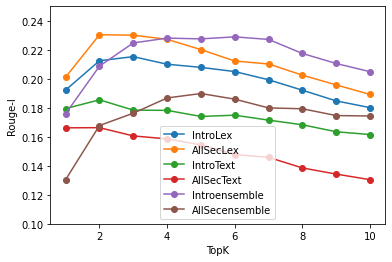

<Figure size 432x288 with 0 Axes>

In [ ]:
x=[1,2,3,4,5,6,7,8,9,10]
f, ax = plt.subplots(1)
ax.plot(x,rouge_l_intro_lex,'-o',label='IntroLex')
ax.plot(x,rouge_l_allsec_lex,'-o',label='AllSecLex')
ax.plot(x,rouge_l_intro_tex,'-o',label='IntroText')
ax.plot(x,rouge_l_allsec_tex,'-o',label='AllSecText')
ax.plot(x,rouge_l_all_50_Intro,'-o',label='Introensemble')
ax.plot(x,rouge_l_all_50_All,'-o',label='AllSecensemble')

ax.set_xlabel('N')
ax.set_ylabel('Rouge-l')
ax.set_ylim(ymin=0.10,ymax=0.25)
plt.legend()
plt.show(f)
plt.savefig('graph.eps',format='eps')

In [ ]:
rouge_l_all_10_All=[0.1426259604572127, 0.17246938914861934, 0.18217928204570846, 0.18224778708835218, 0.17766118049864235, 0.17565346446685554, 0.17379113580781558, 0.16934834563887327, 0.16413754270071407, 0.15762953450181308]
rouge_l_all_10_Intro=[0.16273063109491837, 0.1962157882022984, 0.20031972636284595, 0.19918747003126422, 0.19071282743528253, 0.1820555343380346, 0.17436766062253606, 0.16654162165671438, 0.15988214910257337, 0.15389077652677818]
rouge_l_intro_lex=[0.17308693479169626, 0.18965310873610333, 0.18773039625441557,0.1817747983381817, 0.176244422273372, 0.16974155934621818,0.16327961622322504, 0.15842187413735226, 0.15460434196489192,0.14955373210846398]
rouge_l_allsec_lex=[0.19586025999331452, 0.20940884717328834, 0.21302155852603188,0.2114511900616869, 0.20191385247609267, 0.1953691583821194,0.18956814278895973, 0.18297082416319696, 0.17662767061244708,0.17096631032324555]
rouge_l_intro_tex=[0.1701780143685044, 0.1765714297233547, 0.16994830192289748,0.16504960344563685, 0.15844676177958192, 0.15315247719735567,0.1476836884616376, 0.14310090389921348, 0.1380893845710461,0.134081489135311]
rouge_l_allsec_tex=[0.13871134860761553, 0.14378098741555842, 0.14367887106176339,0.1399794950200046, 0.1378783767072001, 0.1340243668538481,0.13146157621037222, 0.12715443213348762, 0.12351562411678413,0.12097260224719716]

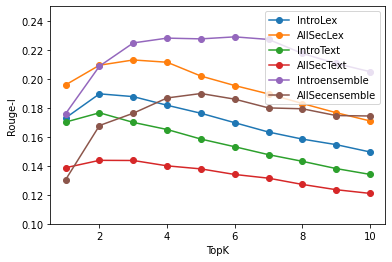

<Figure size 432x288 with 0 Axes>

In [ ]:
x=[1,2,3,4,5,6,7,8,9,10]
f, ax = plt.subplots(1)
ax.plot(x,rouge_l_intro_lex,'-o',label='IntroLex')
ax.plot(x,rouge_l_allsec_lex,'-o',label='AllSecLex')
ax.plot(x,rouge_l_intro_tex,'-o',label='IntroText')
ax.plot(x,rouge_l_allsec_tex,'-o',label='AllSecText')
ax.plot(x,rouge_l_all_50_Intro,'-o',label='Introensemble')
ax.plot(x,rouge_l_all_50_All,'-o',label='AllSecensemble')

ax.set_xlabel('TopK')
ax.set_ylabel('Rouge-l')
ax.set_ylim(ymin=0.10,ymax=0.25)
plt.legend()
plt.show(f)
plt.savefig('graph.eps',format='eps')

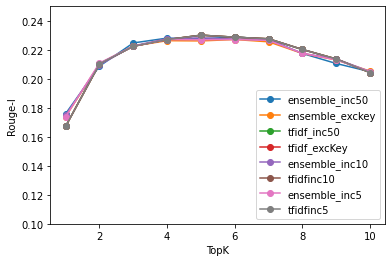

In [ ]:
f, ax = plt.subplots(1)
ax.plot(x,rouge_l_all_50,'-o',label='ensemble_inc50')
ax.plot(x,rouge_l_all_exckey,'-o',label='ensemble_exckey')
ax.plot(x,rouge_l_tfidf_50,'-o',label='tfidf_inc50')
ax.plot(x,rouge_l_tfidf_exckey,'-o',label='tfidf_excKey')
ax.plot(x,rouge_l_all_10,'-o',label='ensemble_inc10')
ax.plot(x,rouge_l_tfidf_10,'-o',label='tfidfinc10')
ax.plot(x,rouge_l_all_5,'-o',label='ensemble_inc5')
ax.plot(x,rouge_l_tfidf_5,'-o',label='tfidfinc5')
ax.set_xlabel('TopK')
ax.set_ylabel('Rouge-l')
ax.set_ylim(ymin=0.10,ymax=0.25)
plt.legend()
plt.show(f)

## An experiment by taking good and bad summaries to validate them 

Code to obtain best summaries based on rouge-l

In [ ]:
arrint=[]
for val in y_rouge_all[0]:
  arrint.append(val['rouge-l']['f'])
arr = np.array(arrint)

indbest=(arr.argsort()[-5:][::-1])

Indexes of bad summaries based on human evalaution

In [ ]:
indleast=[18,39,0,10,44]

In [ ]:
keys=[]
for ke in Highlights.keys():
  keys.append(ke)

In [ ]:

for i in indbest:
  pi.append(str(keys[i]))
for i in indleast:
  pi.append(str(keys[i])) 

13 papers to run the experiments with pi storing the PII of the 13 papers

In [ ]:
len(set(pi))

13

In [ ]:
Intro13={}
AllSec13={}
AllSec13_Dict={}
Highlights13_Dict={}
Abstract13={}
Abstract13_Dict={}
for pii in set(pi):
  Intro13[pii]=Intro[pii]
  AllSec13[pii]=OtherContent[pii]
  AllSec13_Dict[pii]=OtherContent_Dict[pii]
  Highlights13_Dict[pii]=Highlights_Dict[pii]
  Abstract13[pii]=Abstract[pii]
  Abstract13_Dict[pii]=Abstract_Dict[pii]


Generated summary using intro section of the 13 papers and Ensemble method

In [ ]:
genSummaryIntro13

{'s0888613x14000607': ['The empirical loss of a model on interval-valued datasets is defined as the lowest loss over all the possible crisp instantiations (selections) of the uncertain items in the training data',
  'The loss function of a model with fuzzy data is defined as an average over the different level cuts of the data',
  'The model with a best empirical loss is searched for, thus a minimin criterion is adopted',
  'It is shown that this strategy is related to the optimization of certain loss functions used in machine learning',
  'This discussion focuses in on three particular aspects of the paper where further developments may be possible: extension principle-based models, the use of the aforementioned minimin criterion and possible links between data disambiguation and data imputation.'],
 's0888613x1400067x': ['To illustrate the relationship between patterns and granules, we present a method to interpret granules in terms of patterns, and prove that decision rules and max 

Getting the BERTScores of the 13 papers

In [ ]:
cands=[]
refs=[]
generatedSummary={}
    
for key in genSummaryIntro13.keys():
  summattach=''
  for sent in genSummaryIntro13[key]:
    summattach+=sent+" "
  generatedSummary[key]=summattach

for key in Highlights13_Dict.keys():
  cands.append(generatedSummary[key])
  refs.append(Highlights13_Dict[key])
P, R, F1 = score(cands, refs, lang="en", verbose=True)
y1.append(F1)

calculating scores...
computing bert embedding.


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (


computing greedy matching.



done in 52.24 seconds, 0.25 sentences/sec


In [ ]:
F1

tensor([0.8855, 0.8298, 0.8796, 0.7964, 0.8556, 0.8414, 0.8248, 0.8391, 0.8459,
        0.8138, 0.8515, 0.8557, 0.8635])

Obtaining the proposed unsupervised metrics score for the 13 papers

In [ ]:
x=[]
y_rouge_all=[]
y_rouge_tfidf=[]
y_rouge_tr=[]
y1=[] 
y_releditDist_all=[]
y_releditDist_tfidf=[]
y_releditDist_tr=[]
y_RI_all=[]
y_RI_tfidf=[]
y_RI_tr=[]
y_MI_all=[]
y_MI_tfidf=[]
y_MI_tr=[]
y_CO_all=[]
y_CO_tfidf=[]
y_CO_tr=[]
y_wmd_all=[]
y_wmd_tfidf=[]
y_wmd_tr=[]
vectorisers=['TFIDF','Glove100','GoogleNewsModel','RPModel','w2v_ft','w2v_ft_1']
# vectorisers=[]
# score2tf, score22text, genSummaryAllSec13,sentenceindexmain=getSummary(AllSec13,5,methods='all')
generatedSummary={}
# for key in genSummaryIntro.keys():
#   summattach=''
#   for sent in genSummaryIntro[key][:k]:
#     summattach+=sent+" "
#   generatedSummary[key]=summattach
      # generatedSummary=genSummary
# y_rouge_all.append(rouge.get_scores(generatedSummary.values(),Highlights_Dict.values(),avg=False))

for k in range(5,6):
  print(k)
  
  # for key in OtherContent_Dict.keys():
    # parser = PlaintextParser.from_string(Intronew[key],Tokenizer("english"))
    # summarizer = LexRankSummarizer()
    # #Summarize the document with 2 sentences
    # summary=summarizer(parser.document, k)
    # appendStr=''
    # for sent in summary:
    #   appendStr+=str(sent)+" "
    # generatedSummary[key]=appendStr    
  # print(generatedSummary[key])
  # print(Highlightvalue[key])
  # x.append(k)
  for method in ['all','only_tfidfm','only_textRankm']:
    generatedSummary={}
    if method=='all':
      for key in Abstract13.keys():
        summattach=''
        for sent in Abstract13[key]:
          summattach+=sent+" "
        generatedSummary[key]=summattach
      # generatedSummary=genSummary
      # y_rouge_all.append(rouge.get_scores(generatedSummary.values(),Highlights_Dict.values(),avg=False))
      # y_wmd_all.append(1/(1+getWMDScore(generatedSummary,Highlights_Dict)))
      yintrel=[]
      yintRI=[]
      yintMI=[]
      yintCO=[]
      for vectoriser in vectorisers:
        
        generated_Summary_vector_dict,generated_Summary_vector=getVectorisedFormRelMinEdit(generatedSummary,vectoriser)
        OtherContent_vector_dict,OtherContent_vector=getVectorisedFormRelMinEdit(AllSec13_Dict,vectoriser)
        # K,PC,RI,MI,CO=getClusteringResults(vectoriser,OtherContent_vector,generated_Summary_vector,k)
        # cands=[]
        # refs=[]
        # for key in Highlights_Dict.keys():
        #   cands.append(generatedSummary[key])
        #   refs.append(Highlightvalue[key])
        # P, R, F1 = score(cands, refs, lang="en", verbose=True)
        # y1.append(F1.mean())
        # if vectoriser!='TFIDF':
        yintrel.append((getRelativeMinEditDistanceScore(generated_Summary_vector_dict,OtherContent_vector_dict)))
        yintRI.append(RI)
        yintMI.append(MI)
        yintCO.append(CO)
        # y_releditDist.append(yintrel)
      y_RI_all.append(yintRI)
      y_MI_all.append(yintMI)
      y_CO_all.append(yintCO)
      # y_releditDist_all.append(yintrel)



    if method=='only_tfidf':
      for filename in Abstract13_Dict.keys():
        # print(filename)
        mainscore=score2tf[filename]
        summattach=''
        for sent in getSummaryTop(mainscore/mainscore.sum(axis=0,keepdims=1),sentenceindexmain[filename],k):
          summattach+=sent+" "
        generatedSummary[filename]=summattach
      # y_rouge_tfidf.append(rouge.get_scores(generatedSummary.values(),Highlights_Dict.values(),avg=True)['rouge-l']['f'])
      # y_wmd_tfidf.append(1/(1+getWMDScore(generatedSummary,Highlights_Dict)))
      yintrel=[]
      yintRI=[]
      yintMI=[]
      yintCO=[]
      for vectoriser in vectorisers:
        
        generated_Summary_vector_dict,generated_Summary_vector=getVectorisedFormRelMinEdit(generatedSummary,vectoriser)
        OtherContent_vector_dict,OtherContent_vector=getVectorisedFormRelMinEdit(AllSec13_Dict,vectoriser)
        K,PC,RI,MI,CO=getClusteringResults(vectoriser,OtherContent_vector,generated_Summary_vector,k)
        # cands=[]
        # refs=[]
        # for key in Highlights_Dict.keys():
        #   cands.append(generatedSummary[key])
        #   refs.append(Highlightvalue[key])
        # P, R, F1 = score(cands, refs, lang="en", verbose=True)
        # y1.append(F1.mean())
        # if vectoriser!='TFIDF':
        # yintrel.append(1/(1+getRelativeMinEditDistanceScore(generated_Summary_vector_dict,OtherContent_vector_dict)))
        yintRI.append(RI)
        yintMI.append(MI)
        yintCO.append(CO)
        # y_releditDist.append(yintrel)
      y_RI_tfidf.append(yintRI)
      y_MI_tfidf.append(yintMI)
      y_CO_tfidf.append(yintCO)
      # y_releditDist_tfidf.append(yintrel)



    if method=='only_textRank':
      for filename in Abstract13_Dict.keys():
        mainscore=np.array(score22text[filename])
        summattach=''
        for sent in getSummaryTop(mainscore/mainscore.sum(axis=0,keepdims=1),sentenceindexmain[filename],k):
          summattach+=sent+""
        generatedSummary[filename]=summattach
        # generatedSummary[filename]=getSummaryTop(mainscore/mainscore.sum(axis=0,keepdims=1),sentenceindexmain[filename],k)
      # y_rouge_tr.append(rouge.get_scores(generatedSummary.values(),Highlights_Dict.values(),avg=True)['rouge-l']['f'])
      # y_wmd_tr.append(1/(1+getWMDScore(generatedSummary,Highlights_Dict)))
      yintrel=[]
      yintRI=[]
      yintMI=[]
      yintCO=[]
      for vectoriser in vectorisers:
        
        generated_Summary_vector_dict,generated_Summary_vector=getVectorisedFormRelMinEdit(generatedSummary,vectoriser)
        OtherContent_vector_dict,OtherContent_vector=getVectorisedFormRelMinEdit(AllSec13_Dict,vectoriser)
        K,PC,RI,MI,CO=getClusteringResults(vectoriser,OtherContent_vector,generated_Summary_vector,k)
        # cands=[]
        # refs=[]
        # for key in Highlights_Dict.keys():
        #   cands.append(generatedSummary[key])
        #   refs.append(Highlightvalue[key])
        # P, R, F1 = score(cands, refs, lang="en", verbose=True)
        # y1.append(F1.mean())
        # if vectoriser!='TFIDF':
        # yintrel.append(1/(1+getRelativeMinEditDistanceScore(generated_Summary_vector_dict,OtherContent_vector_dict)))
        yintRI.append(RI)
        yintMI.append(MI)
        yintCO.append(CO)
      y_RI_tr.append(yintRI)
      y_MI_tr.append(yintMI)
      y_CO_tr.append(yintCO)
      




    
 

In [ ]:
yintrel

[[0.1111111111111111,
  0.1111111111111111,
  0.08333333333333333,
  0.09090909090909091,
  0.1,
  0.1,
  0.14285714285714285,
  0.08333333333333333,
  0.125,
  0.1,
  0.125,
  0.09090909090909091,
  0.1111111111111111],
 [0.1,
  0.1111111111111111,
  0.08333333333333333,
  0.1,
  0.09090909090909091,
  0.09090909090909091,
  0.1111111111111111,
  0.1,
  0.14285714285714285,
  0.09090909090909091,
  0.1,
  0.1,
  0.1],
 [0.1,
  0.1111111111111111,
  0.1,
  0.1,
  0.07692307692307693,
  0.09090909090909091,
  0.1,
  0.125,
  0.1111111111111111,
  0.1111111111111111,
  0.125,
  0.1111111111111111,
  0.1],
 [0.1111111111111111,
  0.14285714285714285,
  0.09090909090909091,
  0.1111111111111111,
  0.1,
  0.1,
  0.1111111111111111,
  0.09090909090909091,
  0.125,
  0.1111111111111111,
  0.125,
  0.09090909090909091,
  0.1],
 [0.1,
  0.1111111111111111,
  0.09090909090909091,
  0.09090909090909091,
  0.08333333333333333,
  0.08333333333333333,
  0.125,
  0.1,
  0.1,
  0.1,
  0.08333333333333

In [ ]:
print(y_RI_all[0])
# print(y_RI_tfidf)
# print(y_RI_tr)
print(y_MI_all[0])
# print(y_MI_tfidf)
# print(y_MI_tr)
print(y_CO_all[0])
# print(y_CO_tfidf)
# print(y_CO_tr)

[0.2857142857142857, 0.42689199118295373, 0.675270607826811, 0.5085910652920962, 0.14548641542506577, 0.21739130434782608]
[0.3200276030198358, 0.461369438047048, 0.6193246945278013, 0.49422457635816913, 0.23219791458667724, 0.2595066203679777]
[0.6335746577001036, 0.7221664588122686, 0.7993662851566852, 0.7530280510604582, 0.5678413828684131, 0.6067801978664913]


In [ ]:
print(x)
print(y_rouge_all)
print(y_rouge_tfidf)
print(y_rouge_tr)
print(y1)
print(y_releditDist_all)
print(y_releditDist_tfidf)
print(y_releditDist_tr)
print(y_RI_all)
print(y_RI_tfidf)
print(y_RI_tr)
print(y_MI_all)
print(y_MI_tfidf)
print(y_MI_tr)
print(y_CO_all)
print(y_CO_tfidf)
print(y_CO_tr)
print(y_wmd_all)
print(y_wmd_tfidf)
print(y_wmd_tr)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.12474161770579299, 0.17291258033160511, 0.17821528835669195, 0.17676910910047267, 0.18014267767988, 0.18138869994599252, 0.17890617686057797, 0.17646104025048706, 0.17109868377982237, 0.17039820342146103]
[0.15365304219271153, 0.18389976067717526, 0.1875797096065861, 0.19214851828461504, 0.19151334339622794, 0.19031807488218117, 0.18946595787264986, 0.18596636370896244, 0.1847721163651654, 0.178596020221129]
[0.12204944119707066, 0.14739211780818376, 0.15257946005408993, 0.1523352689765601, 0.14957908569638625, 0.14597966667940396, 0.14195681327846765, 0.14185130835887363, 0.139300733561925, 0.1364222931346795]
[]
[[0.01586139580283065, 0.015907978463044543, 0.015904086126743332, 0.016101065147386674, 0.015939185875429134, 0.016149068322981366], [0.015939185875429134, 0.016141047926496153, 0.016165133051479732, 0.01638930912758447, 0.016173177407315255, 0.01634397787276842], [0.01586526726873322, 0.016177202588352414, 0.016258129064532265, 0.016468203